# **Recurrent Neural Networks || RNNs**

<!-- HTML block in markdown -->
<div class="container">
    <div class="title">RNN Flow Diagram</div>
    <img class="image" src="https://miro.medium.com/v2/resize:fit:1200/1*ccHxugJhQo7VH4GAAZt3Sg.png" alt="RNN Flow Diagram">
</div>

<style>
    .container {
        text-align: center;
    }
    .image {
        width: 80%;
        margin: 0 auto;
    }
    .title {
        text-align: center;
        font-size: 24px;
        font-weight: bold;
        margin-top: 20px;
    }
</style>


**RNNs are usually used in NLP, Image Classification and Speech Recognition**

### **1. Utility File -> utils.py => UnicodeToAscii, Loading Data, Indexing Data, Conversion into Tensor**

In [24]:
# %%writefile modules/_01_utils.py
import io
import os
import unicodedata
import string
import glob

import torch
import random

ALL_LETTERS = string.ascii_letters + " .,;'"  #Small + Capital + ,;.
N_LETTERS = len(ALL_LETTERS)

# Turn a Unicode string to plain ASCII, We can use unidecode
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []
    
    def find_files(path):
        return glob.glob(path)
    
    # Read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]
    
    for filename in find_files('data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        
        lines = read_lines(filename)
        category_lines[category] = lines
        
    return category_lines, all_categories


# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor


def random_training_example(category_lines, all_categories):
    
    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]
    
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor



if __name__ == '__main__':
    print(ALL_LETTERS)
    # print(unicode_to_ascii('Ślusàrski'))
    
    # category_lines, all_categories = load_data()
    # print(category_lines['Italian'][:5])
    
    # print(letter_to_tensor('J')) # [1, 57]
    # print(line_to_tensor('Jones').size()) # [5, 1, 57]


Overwriting modules/_01_utils.py


### **2. RNN ->**

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>RNN Architecture</title>
    <style>
        .container {
            text-align: center;
        }
        .image {
            width: 80%;
            margin: 0 auto;
        }
        .title {
            text-align: center;
            font-size: 24px;
            font-weight: bold;
            margin-top: 20px;
        }
    </style>
</head>
<body>
    <div class="container">
        <div class="title">RNN Architecture</div>
        <img class="image" src="https://ml-cheatsheet.readthedocs.io/en/latest/_images/rnn.png" alt="RNN Architecture">
    </div>
</body>
</html>


#### **``02_rnn.py`` -> Builds the RNN Model Architecture, Initiates the Model Instance, Trains the Model, Plots the Loss Curve & Predicts on Custom Input Data**

 10%|█         | 10145/100000 [00:09<01:28, 1018.16it/s]

10000 10.0 1.2783 Fiscella / Italian CORRECT


 20%|██        | 20234/100000 [00:18<01:10, 1131.72it/s]

20000 20.0 2.0601 Hopes / Dutch WRONG (English)


 30%|███       | 30233/100000 [00:27<01:04, 1077.30it/s]

30000 30.0 1.1497 D'cruz / Spanish WRONG (Portuguese)


 40%|████      | 40165/100000 [00:36<00:54, 1105.08it/s]

40000 40.0 1.7507 Li / Vietnamese WRONG (Korean)


 50%|█████     | 50147/100000 [00:46<00:43, 1156.12it/s]

50000 50.0 0.1654 Thean / Chinese CORRECT


 60%|██████    | 60151/100000 [00:55<00:37, 1072.54it/s]

60000 60.0 0.4239 Chan / Chinese CORRECT


 70%|███████   | 70129/100000 [01:04<00:26, 1143.63it/s]

70000 70.0 0.0262 Mcintyre / Scottish CORRECT


 80%|████████  | 80113/100000 [01:13<00:17, 1150.13it/s]

80000 80.0 0.2302 De santigo / Portuguese CORRECT


 90%|█████████ | 90140/100000 [01:22<00:08, 1153.06it/s]

90000 90.0 2.5875 Potenza / Portuguese WRONG (Italian)


100%|██████████| 100000/100000 [01:31<00:00, 1096.21it/s]

100000 100.0 0.0611 You / Korean CORRECT


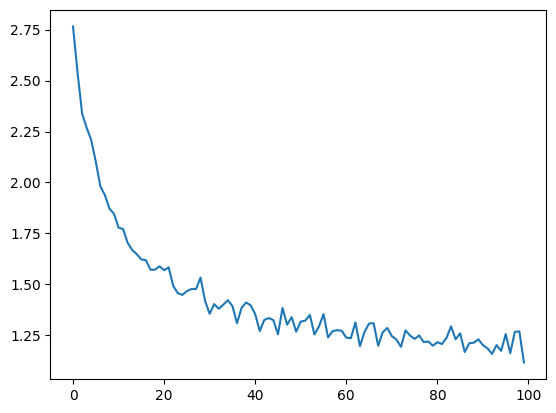


> Putin
Russian

> Yamaha
Japanese

> Rodriguez
Spanish

> Panini
Italian


In [31]:
# %%writefile modules/_02_rnn.py
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
from modules._01_utils import *

class RNN(nn.Module):
    
    def __init__(self,
                 input_size,
                 hidden_size,
                 output_size) -> None:
        super(RNN,self).__init__()
        
        self.hidden_size = hidden_size 
        self.i2h = nn.Linear(input_size + hidden_size , hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size , output_size)
        
        self.softmax = nn.LogSoftmax(dim = 1)
        
    
    def forward(self, input_tensor, hidden_tensor):
        combined_tensor = torch.cat((input_tensor, hidden_tensor),1)
        
        hidden = self.i2h(combined_tensor)
        output = self.i2o(combined_tensor)
         
        output = self.softmax(output)
        return output, hidden
    
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)
    
category_lines, all_categories = load_data()
num_categories = len(all_categories)

rnn_model = RNN(input_size=N_LETTERS, hidden_size=128, output_size=num_categories)


def category_from_output(output):
    
    cat = output.argmax(dim=1).item()
    return all_categories[cat]


#Training part -> 

loss_fn = torch.nn.NLLLoss()

# Create the Adam optimizer
optimizer = torch.optim.RMSprop(rnn_model.parameters(), 0.0005 )



def train(line_tensor, category_tensor):
    hidden = rnn_model.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output,hidden = rnn_model(line_tensor[i], hidden)
        
    train_loss = loss_fn(output, category_tensor)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    return output, train_loss.item()

current_loss = 0
all_loss_values = []
plot_steps , print_steps = 1000 , 10000 
n_iterations = 100000


for i in tqdm(range(n_iterations)):
    category , line , category_tensor, line_tensor = random_training_example(category_lines=category_lines, all_categories=all_categories)
    
    output , loss = train(line_tensor=line_tensor, category_tensor=category_tensor)
    
    current_loss+= loss
    
    if (i+1) % plot_steps == 0:
        all_loss_values.append(current_loss / plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iterations*100} {loss:.4f} {line} / {guess} {correct}")
    


#Plotting the loss values
plt.figure()
plt.plot(all_loss_values)
plt.show()


#Predicting on Custom Input Data
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = rnn_model.init_hidden()
    
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn_model(line_tensor[i], hidden)
        
        guess = category_from_output(output)
        print(guess)


while True:
    sentence = input("Type 'quit' to stop. Enter Input -> ")
    if sentence == "quit":
        break
    
    predict(sentence)
